1. Proof (Policy Invariance)
Goal: Show that for any finite episode where the potential of the terminal state $\Phi(G) = 0$, the shaped return $\hat{G}_t$ and the original return $G_t$ are related by $\hat{G}_t = G_t - \Phi(S_t)$. From this, deduce the relationship between the Q-values and prove that the optimal action remains the same.

Proof:

The definition of the total return from time $t$ until a terminal state $S_n$ is reached is:


$​G_t = \sum_{k=0}^{n-t-1} \gamma^k R_{t+k+1}$
 
The shaped return is defined similarly, using the shaped reward $\hat{R}$:


$\hat{G}_t = \sum_{k=0}^{n-t-1} \gamma^k \hat{R}_{t+k+1}$
​
 
We are given the potential-based reward shaping formula:
$$ \hat{R}(s, a, s') = R(s, a, s') + \gamma\Phi(s') - \Phi(s) $$
In terms of time steps, this is $\hat{R}_{t+1} = R_{t+1} + \gamma\Phi(S_{t+1}) - \Phi(S_t)$.

Let's expand the sum for the shaped return $\hat{G}_t$:
$$ \hat{G}t = \hat{R}{t+1} + \gamma\hat{R}{t+2} + \gamma^2\hat{R}{t+3} + \dots $$
$$ \hat{G}t = (R{t+1} + \gamma\Phi(S_{t+1}) - \Phi(S_t)) + \gamma(R_{t+2} + \gamma\Phi(S_{t+2}) - \Phi(S_{t+1})) + \gamma^2(R_{t+3} + \gamma\Phi(S_{t+3}) - \Phi(S_{t+2})) + \dots $$

If we rearrange the terms, we see a telescoping series:
$$ \hat{G}t = (R{t+1} + \gamma R_{t+2} + \dots) - \Phi(S_t) + (\gamma\Phi(S_{t+1}) - \gamma\Phi(S_{t+1})) + (\gamma^2\Phi(S_{t+2}) - \gamma^2\Phi(S_{t+2})) + \dots + \gamma^{n-t}\Phi(S_n) $$

All the intermediate $\Phi$ terms cancel out. We are left with:
$$ \hat{G}t = \left(\sum{k=0}^{n-t-1} \gamma^k R_{t+k+1}\right) - \Phi(S_t) + \gamma^{n-t}\Phi(S_n) $$
$$ \hat{G}_t = G_t - \Phi(S_t) + \gamma^{n-t}\Phi(S_n) $$

Given that the terminal state is $G$ (so $S_n = G$) and $\Phi(G) = 0$, the last term becomes zero.
Therefore, we have proven:
$$ \hat{G}_t = G_t - \Phi(S_t) $$

Deduction for Q-values:
The action-value function $Q^\pi(s, a)$ is the expected return for taking action $a$ in state $s$ and then following policy $\pi$.
$$ \hat{Q}^\pi(s, a) = E_\pi[\hat{G}t | S_t=s, A_t=a] $$
Substitute our proven result for $\hat{G}_t$:
$$ \hat{Q}^\pi(s, a) = E\pi[G_t - \Phi(S_t) | S_t=s, A_t=a] $$
Since $S_t=s$ is given, $\Phi(S_t)$ is just $\Phi(s)$, which is a constant and not subject to the expectation.
$$ \hat{Q}^\pi(s, a) = E_\pi[G_t | S_t=s, A_t=a] - \Phi(s) $$
$$ \hat{Q}^\pi(s, a) = Q^\pi(s, a) - \Phi(s) $$

Deduction for Optimal Action:
To find the optimal policy, we select the action that maximizes the Q-value in each state.
$$ \arg\max_a \hat{Q}(s, a) = \arg\max_a (Q(s, a) - \Phi(s)) $$
The term $\Phi(s)$ is constant for all actions $a$ being considered in a given state $s$. Therefore, it does not influence which action has the maximum value.
$$ \arg\max_a \hat{Q}(s, a) = \arg\max_a Q(s, a) $$

This proves that the optimal policy is unchanged by the reward shaping, demonstrating policy invariance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML # For displaying in notebooks

class GridWorld:
    def __init__(self, height=5, width=5, agent_location=None, target_location=None):
        self.size = (height, width)
        self.action_space_size = 5  # 0: up, 1: down, 2: left, 3: right, 4: stay
        self.action2direction = {
            0: np.array([-1, 0]),  # up
            1: np.array([1, 0]),   # down
            2: np.array([0, -1]),  # left
            3: np.array([0, 1]),   # right
            4: np.array([0, 0])    # stay  <- CORRECTED
        }
        
        # Store initial locations to be used by reset()
        self._initial_agent_location = agent_location
        self._initial_target_location = target_location

        self.target_location = self._initial_target_location
        if self.target_location is None:
            self.target_location = (np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1]))

        self.agent_location = self._initial_agent_location
        if self.agent_location is None:
            while True:
                self.agent_location = (np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1]))
                if self.agent_location != self.target_location:
                    break
        # Store the true starting point after potential randomization
        self._initial_agent_location = self.agent_location
        
        self.history = []
        self.reset()

    def get_state_space_size(self):
        return self.size[0] * self.size[1]
    
    def get_all_states(self):
        states = []
        for r in range(self.size[0]):
            for c in range(self.size[1]):
                states.append((r,c))
        return states

    def reset(self):
        """ Resets the agent to its initial starting position. """
        self.agent_location = self._initial_agent_location
        self.history = [{'agent': self.agent_location, 'target': self.target_location, 'reward': 0}]
        return self.agent_location

    def step(self, action):
        agent_pos = np.array(self.agent_location)
        direction = self.action2direction[action]
        next_pos = agent_pos + direction

        # Check boundaries
        if (0 <= next_pos[0] < self.size[0]) and (0 <= next_pos[1] < self.size[1]):
            self.agent_location = tuple(next_pos)

        finished = (self.agent_location == self.target_location)
        reward = 10 if finished else -1

        self.history.append({'agent': self.agent_location, 'target': self.target_location, 'reward': reward})
        return self.agent_location, reward, finished

    def set_history(self, history):
        """Allows a solver to set the history for visualization."""
        self.history = history

    def Create_Visualization(self):
        fig, ax = plt.subplots(figsize=(7, 8))
        fig.subplots_adjust(bottom=0.15)
    
        def setup_grid():
            ax.set_xlim(-0.5, self.size[1] - 0.5)
            ax.set_ylim(-0.5, self.size[0] - 0.5)
    
            ax.set_xticks(np.arange(-0.5, self.size[1], 1), minor=True)
            ax.set_yticks(np.arange(-0.5, self.size[0], 1), minor=True)
            ax.grid(which='minor', color='#CCCCCC', linestyle='-', linewidth=1)
            ax.tick_params(which='minor', bottom=False, left=False, labelbottom=False, labelleft=False)
            ax.set_aspect('equal', adjustable='box')
            ax.invert_yaxis()
    
        setup_grid()
    
        # target drawing
        target_pos = self.history[0]['target']
        ax.scatter(target_pos[1], target_pos[0], marker=(5, 1, 0), s=800, c='#FFD700',
                   edgecolors='black', zorder=5, label='Target')
    
        # agent + path drawing
        agent_marker = ax.scatter([], [], s=400, c='#0077BE', edgecolors='white',
                                   linewidth=2, zorder=5, label='Agent')
        path_line, = ax.plot([], [], color='#0077BE', alpha=0.5, linewidth=4, zorder=4)
    
        ax.legend(loc='upper right')
    
        info_text = fig.text(0.5, 0.05, '', ha='center', fontsize=16, fontweight='bold',
                             bbox=dict(boxstyle='round,pad=0.5', fc='lightgray', alpha=0.5))
    
        cumulative_rewards = np.cumsum([frame['reward'] for frame in self.history])
    
        def update(frame_num):
            current_frame = self.history[frame_num]
            agent_pos = current_frame['agent']
    
            # Update agent
            agent_marker.set_offsets([agent_pos[1], agent_pos[0]])
    
            # Update path
            path_rows, path_cols = zip(*[f['agent'] for f in self.history[:frame_num + 1]])
            path_line.set_data(path_cols, path_rows)
    
            # Title and info text
            ax.set_title(f"Agent at: {agent_pos}", fontsize=14)
            total_reward_so_far = cumulative_rewards[frame_num]
            info_text.set_text(f"Step: {frame_num:02d}     |     Cumulative Reward: {total_reward_so_far}")
    
            if frame_num == len(self.history) - 1 and agent_pos == target_pos:
                ax.set_title("Target Reached!", fontsize=16, color='green')
    
            return agent_marker, path_line, info_text
    
        anim = FuncAnimation(fig, update, frames=len(self.history), interval=250, blit=False)
    
        plt.close(fig)
        return anim

    def manhattan_distance(self, s1, s2):
        return abs(s1[0] - s2[0]) + abs(s1[1] - s2[1])

    def potential(self, s):
        """Φ(s) = -Manhattan distance to goal, Φ(G)=0"""
        if s == self.target_location:
            return 0.0
        return -float(self.manhattan_distance(s, self.target_location))

    def step_with_shaping(self, action, gamma):
        """Step using reward shaping: R̂(s,a,s′)=R+γΦ(s′)−Φ(s)."""
        s = self.agent_location
        s_prime, base_reward, done = self.step(action)
        shaped_reward = base_reward + gamma * self.potential(s_prime) - self.potential(s)
        return s_prime, shaped_reward, done


class Solver:
    def __init__(self, env, discount_factor=0.99):
        self.env = env
        self.gamma = discount_factor
        self.policy = np.zeros(self.env.size, dtype=int)

    def solve(self):
        """Learns the optimal policy."""
        raise NotImplementedError("This method should be implemented by a subclass.")

    def get_policy(self):
        return self.policy
    
    def plot_policy(self):
        """Visualizes the learned policy using arrows."""
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.set_xlim(-0.5, self.env.size[1] - 0.5)
        ax.set_ylim(-0.5, self.env.size[0] - 0.5)
        ax.set_xticks(np.arange(-0.5, self.env.size[1], 1))
        ax.set_yticks(np.arange(-0.5, self.env.size[0], 1))
        ax.grid(which='major', color='#CCCCCC', linestyle='-', linewidth=1)
        ax.tick_params(which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.invert_yaxis()
        ax.set_title("Learned Policy", fontsize=16)

        target_pos = self.env.target_location
        start_pos = self.env._initial_agent_location
        ax.scatter(target_pos[1], target_pos[0], marker=(5, 1, 0), s=1000, c='#FFD700', edgecolors='black', zorder=5, label='Target')
        if start_pos:
            ax.scatter(start_pos[1], start_pos[0], s=500, c='#0077BE', edgecolors='white', linewidth=2, zorder=5, label='Start')

        rows, cols = np.indices(self.env.size)
        col_coords = cols.flatten()
        row_coords = rows.flatten()
        
        policy_actions = self.policy.flatten()
        action_vectors = np.array([self.env.action2direction[a] for a in policy_actions])
        
        dy = action_vectors[:, 0]
        dx = action_vectors[:, 1]

        target_flat_idx = target_pos[0] * self.env.size[1] + target_pos[1]
        dx[target_flat_idx] = 0
        dy[target_flat_idx] = 0

        ax.quiver(col_coords, row_coords, dx, -dy, scale=35, color='#333333', headwidth=4, headlength=5, pivot='mid')

        ax.legend(loc='upper right')
        plt.show()

    def run_simulation(self, max_steps=100):
        """Runs one episode using the learned policy and returns the history."""
        self.env.reset()
        history = [self.env.history[0].copy()] 
        
        for _ in range(max_steps):
            current_state = self.env.agent_location
            action = self.policy[current_state]
            _, _, finished = self.env.step(action)
            history.append(self.env.history[-1])
            if finished:
                break
        return history

class ValueIterationSolver(Solver):
    def __init__(self, env, discount_factor=0.99, theta=1e-6):
        super().__init__(env, discount_factor)
        self.theta = theta
        self.value_table = np.zeros(self.env.size)

    def _get_action_value(self, state, action):
        original_pos = self.env.agent_location
        self.env.agent_location = state
        
        next_state, reward, _ = self.env.step(action)
        action_value = reward + self.gamma * self.value_table[next_state]
        
        self.env.agent_location = original_pos
        return action_value

    def solve(self):
        print("Starting Value Iteration...")
        delta = float('inf')
        
        while delta > self.theta:
            delta = 0
            for r in range(self.env.size[0]):
                for c in range(self.env.size[1]):
                    state = (r, c)
                    if state == self.env.target_location:
                        continue
                        
                    old_value = self.value_table[state]
                    action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                    
                    self.value_table[state] = max(action_values)
                    delta = max(delta, abs(old_value - self.value_table[state]))

        print("Value Iteration Converged.")
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                state = (r, c)
                action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                self.policy[state] = np.argmax(action_values)

class PolicyIterationSolver(Solver):
    def __init__(self, env, discount_factor=0.99, theta=1e-6):
        super().__init__(env, discount_factor)
        self.theta = theta
        self.value_table = np.zeros(self.env.size)
        self.policy = np.random.randint(0, self.env.action_space_size, self.env.size)

    def _get_action_value(self, state, action):
        original_pos = self.env.agent_location
        self.env.agent_location = state
        
        next_state, reward, _ = self.env.step(action)
        action_value = reward + self.gamma * self.value_table[next_state]
        
        self.env.agent_location = original_pos
        return action_value

    def _policy_evaluation(self):
        delta = float('inf')
        while delta > self.theta:
            delta = 0
            for r in range(self.env.size[0]):
                for c in range(self.env.size[1]):
                    state = (r, c)
                    old_value = self.value_table[state]
                    action = self.policy[state]
                    self.value_table[state] = self._get_action_value(state, action)
                    delta = max(delta, abs(old_value - self.value_table[state]))

    def _policy_improvement(self):
        policy_stable = True
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                state = (r, c)
                old_action = self.policy[state]
                
                action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                self.policy[state] = np.argmax(action_values)
                
                if old_action != self.policy[state]:
                    policy_stable = False
        return policy_stable

    def solve(self):
        print("Starting Policy Iteration...")
        policy_stable = False
        iteration = 1
        while not policy_stable:
            print(f"  Iteration {iteration}...")
            self._policy_evaluation()
            policy_stable = self._policy_improvement()
            iteration += 1
        print("Policy Iteration Converged.")


# ===================================================================
# NEW: Q-Learning Solver
# ===================================================================
class QLearningSolver(Solver):
    def __init__(self, env, discount_factor=0.99,
                 num_episodes=5000, learning_rate=0.1,
                 epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01):
        super().__init__(env, discount_factor)
        self.num_episodes = num_episodes
        self.alpha = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros(self.env.size + (self.env.action_space_size,))

    def _choose_action(self, state):
        """Chooses an action using an epsilon-greedy policy."""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.env.action_space_size)  # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def solve(self, max_steps_per_episode=100, use_shaping=False):
        print(f"Starting Q-Learning (shaping={use_shaping})...")
        np.random.seed(123)

        success_rate_window = []
        success_count = 0
        total_success = 0

        for episode in range(self.num_episodes):
            state = self.env.reset()
            done = False
            success = False

            for _ in range(max_steps_per_episode):
                action = self._choose_action(state)
                if use_shaping:
                    next_state, reward, done = self.env.step_with_shaping(action, self.gamma)
                else:
                    next_state, reward, done = self.env.step(action)
                
                # Q-update
                old_value = self.q_table[state][action]
                next_max = np.max(self.q_table[next_state])
                self.q_table[state][action] = old_value + self.alpha * (
                    reward + self.gamma * next_max - old_value
                )

                state = next_state
                if done:
                    success = True
                    break

            # Track success rate in sliding window
            success_rate_window.append(1 if success else 0)
            if len(success_rate_window) > 50:
                success_rate_window.pop(0)
            success_rate = np.mean(success_rate_window)

            if success_rate >= 0.95 and len(success_rate_window) >= 50:
                print(f"✔ Success ≥95% at episode {episode+1}")
                break

            # Epsilon decay rule
            self.epsilon = max(0.05, 0.2 - episode / 500)

        print("Q-Learning Finished.")
        self.policy = np.argmax(self.q_table, axis=2)



# ===================================================================
# NEW: Monte Carlo Solver
# ===================================================================
class MonteCarloSolver(Solver):
    def __init__(self, env, discount_factor=0.99,
                 num_episodes=20000, epsilon=1.0, 
                 epsilon_decay=0.9999, min_epsilon=0.01):
        super().__init__(env, discount_factor)
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros(self.env.size + (self.env.action_space_size,))
        self.returns_sum = np.zeros_like(self.q_table)
        self.returns_count = np.zeros_like(self.q_table, dtype=float)

    def _get_policy_for_episode_generation(self):
        """Creates an epsilon-greedy policy from the current Q-table."""
        policy = np.ones(self.env.size + (self.env.action_space_size,)) * self.epsilon / self.env.action_space_size
        best_actions = np.argmax(self.q_table, axis=2)
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                policy[r, c, best_actions[r, c]] += (1.0 - self.epsilon)
        return policy

    def solve(self, max_episode_steps=100):
        print("Starting Monte Carlo Control...")
        
        for episode_num in range(self.num_episodes):
            # 1. Generate an episode using the current epsilon-greedy policy
            episode = []
            state = self.env.reset()
            
            # Get the current policy for action selection
            prob_policy = self._get_policy_for_episode_generation()

            for _ in range(max_episode_steps):
                # Choose action based on the probability distribution for the state
                action = np.random.choice(self.env.action_space_size, p=prob_policy[state])
                next_state, reward, done = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state
                if done:
                    break
            
            # 2. Update Q-values using the generated episode (First-Visit)
            G = 0
            visited_state_actions = set()
            for state, action, reward in reversed(episode):
                sa_pair = (state, action)
                if sa_pair not in visited_state_actions:
                    G = reward + self.gamma * G
                    self.returns_sum[state][action] += G
                    self.returns_count[state][action] += 1.0
                    self.q_table[state][action] = self.returns_sum[state][action] / self.returns_count[state][action]
                    visited_state_actions.add(sa_pair)

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            
            if (episode_num + 1) % 2000 == 0:
                print(f"  Episode {episode_num + 1}/{self.num_episodes} | Epsilon: {self.epsilon:.4f}")

        print("Monte Carlo Finished.")
        # 3. Extract final greedy policy from the learned Q-values
        self.policy = np.argmax(self.q_table, axis=2)



Starting Q-Learning (shaping=True)...
✔ Success ≥95% at episode 50
Q-Learning Finished.


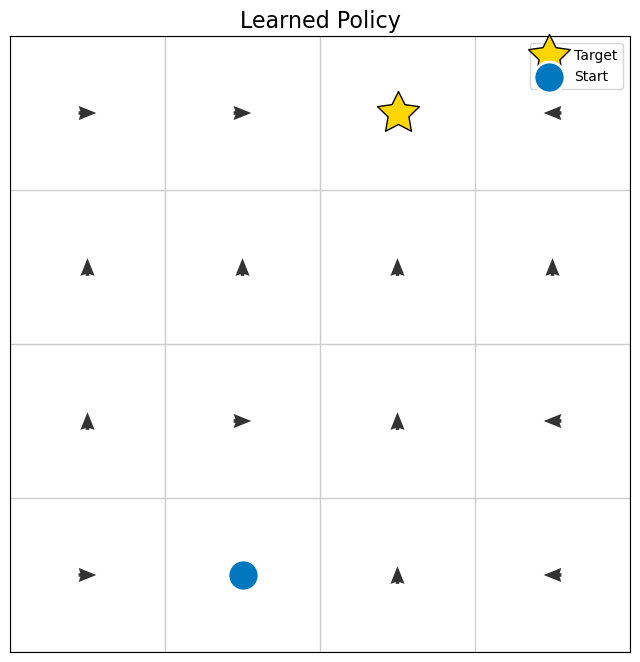

In [12]:
GRID_HEIGHT = 4
GRID_WIDTH = 4
AGENT_START = None
TARGET_POS = None

env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)

solver = QLearningSolver(env, discount_factor=0.9, learning_rate=0.1, num_episodes=5000)
solver.solve(use_shaping=True)

solver.plot_policy()
history = solver.run_simulation(max_steps=100)
env.set_history(history)
anim = env.Create_Visualization()
HTML(anim.to_html5_video())


Starting Q-Learning (shaping=False)...
✔ Success ≥95% at episode 50
Q-Learning Finished.


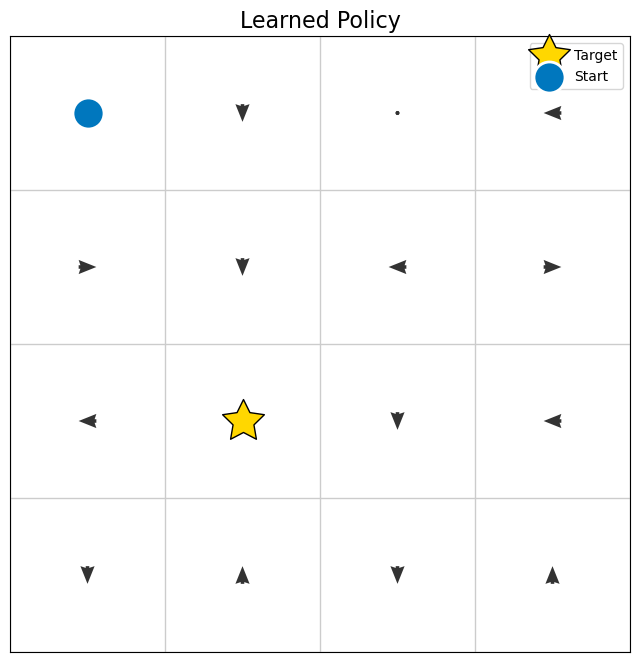

In [16]:
GRID_HEIGHT = 4
GRID_WIDTH = 4
AGENT_START = None
TARGET_POS = None

env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)

solver = QLearningSolver(env, discount_factor=0.9, learning_rate=0.1, num_episodes=5000)
solver.solve(use_shaping=False)

solver.plot_policy()
history = solver.run_simulation(max_steps=100)
env.set_history(history)
anim = env.Create_Visualization()
HTML(anim.to_html5_video())


3. Verifications Exigées
This step involves analyzing the results from the implementation in exercise 2.

Invariance de politique: Compare the final greedy policies extracted from both the shaped and unshaped Q-tables. According to the proof in exercise 1, the two policies must be identical. Any difference would indicate an error in the implementation.

Gain d'apprentissage: Compare the number of episodes it took for each implementation to reach the 95% success threshold. The condition is that the number of episodes with shaping should be $\le$ 70% of the number of episodes without shaping. This quantifies the learning speed-up. For example, if the standard algorithm took 500 episodes, the shaped one should take 350 or fewer.

4. Contre-exemple (piège)
This exercise demonstrates what happens when the conditions for policy invariance are not met.

Scenario: We use an incorrect potential function, for example, by setting $\Phi(G) \neq 0$. Let's assume $\Phi(G) = 10$.

Explanation:
The proof of policy invariance in exercise 1 critically depends on the $\gamma^{n-t}\Phi(S_n)$ term becoming zero. If $\Phi(G) \neq 0$, the relationship becomes:
$$ \hat{G}_t = G_t - \Phi(S_t) + \gamma^{n-t}\Phi(G) $$

The additional term $\gamma^{n-t}\Phi(G)$ is a bonus (or penalty) that depends on the number of steps $(n-t)$ taken to reach the goal. A shorter path to the goal results in a larger value for this term.

Consequently, the relationship between Q-values is no longer a simple offset:
$$ \hat{Q}^\pi(s, a) \neq Q^\pi(s, a) - \Phi(s) $$

The agent is now optimizing for a different objective. It's not just trying to maximize the original return $G_t$, but a combination of $G_t$ and a bonus for reaching the terminal state quickly. This changes the relative values of different state-action pairs, and as a result, the optimal policy can change. The agent might learn a policy that is suboptimal for the original problem because it has been biased by the incorrect potential function.

In short, violating the condition $\Phi(\text{terminal}) = 0$ breaks the theoretical guarantee of policy invariance, leading to a potentially different and incorrect final policy.